# Import packages

In [ ]:
import os
import cmaps
import cmocean
import numpy as np
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from netCDF4 import Dataset
from datetime import date
from mpl_toolkits.basemap import Basemap
from matplotlib.pyplot import Polygon
from matplotlib import rcParams
from xarrayMannKendall import Mann_Kendall_test
directory   = '/srv/scratch/z3533156'
from dask.distributed import Client
from astropy import convolution
rcParams['font.family'] = 'sans-serif'
import PUG_functions as PF

# Read SSH data

In [ ]:
dataset = xr.open_dataset(directory+'/BRAN_WBC/SO/AVISO/AVISO_monthly_SSH_LS_detrend.nc')
lon = np.tile(dataset.lon, (len(dataset.lat[40:242]),1)).transpose()+180
lat = np.tile(dataset.lat[40:242], (len(dataset.lon),1))
large_scale_ssh0 = dataset.adt.transpose().values
large_scale_ssh1=np.concatenate((large_scale_ssh0[720:,40:242,:],large_scale_ssh0[:720,40:242,:]),axis=0)
large_scale_ssh2=large_scale_ssh1.copy()
large_scale_ssh3=large_scale_ssh1.copy()
large_scale_ssh1[:60,:,:]=np.nan;
large_scale_ssh1[485:,:,:]=np.nan;
large_scale_ssh2[:579,:,:]=np.nan;
large_scale_ssh2[1201:,:,:]=np.nan;
large_scale_ssh3[:1225,:,:]=np.nan;
dataset1   = sio.loadmat(directory+'/BRAN_WBC/SO/Figure4_lat_SG_WBC_detrend.mat')
lon0       = dataset1['lon0'][:,0]
lat_SG     = dataset1['lat_SG']
lat_SG_ARC_trend = dataset1['lat_SG_ARC_trend'][:,0]
lat_SG_EAC_trend = dataset1['lat_SG_EAC_trend'][:,0]
lat_SG_BC_trend  = dataset1['lat_SG_BC_trend'][:,0]
lat_SG_ARC_mean  = dataset1['lat_SG_ARC_mean'][:,0]
lat_SG_EAC_mean  = dataset1['lat_SG_EAC_mean'][:,0]
lat_SG_BC_mean   = dataset1['lat_SG_BC_mean'][:,0]
lat_SG_mean      = np.array((lat_SG_ARC_mean,lat_SG_EAC_mean,lat_SG_BC_mean))
###################################################################################################
ds = xr.Dataset(data_vars=dict(lat_SG_mean=(["latitude","time"], lat_SG_mean)))
lat_SG_WBC_mean0 = ds.lat_SG_mean
lat_SG_WBC_mean1 = lat_SG_WBC_mean0.sortby('time')
lat_SG_WBC_mean  = Mann_Kendall_test(lat_SG_WBC_mean1,'time',MK_modified=True,method="linregress",alpha=0.05,
                                coords_name = {'time':'time','x':'latitude'})
lat_SG_WBC_mean_trend = lat_SG_WBC_mean.compute()
time_start = np.datetime64('1993-07')
time_end   = np.datetime64('2020-08')
t_range    = PF.time_range(time_start,time_end,'monthly','np64')
x_lon      = np.tile(lon0,(np.size(t_range),1)).transpose()
y_month    = np.tile(t_range,(np.shape(lon0)[0],1))

# Plot the Subtropical Ocean Gyres

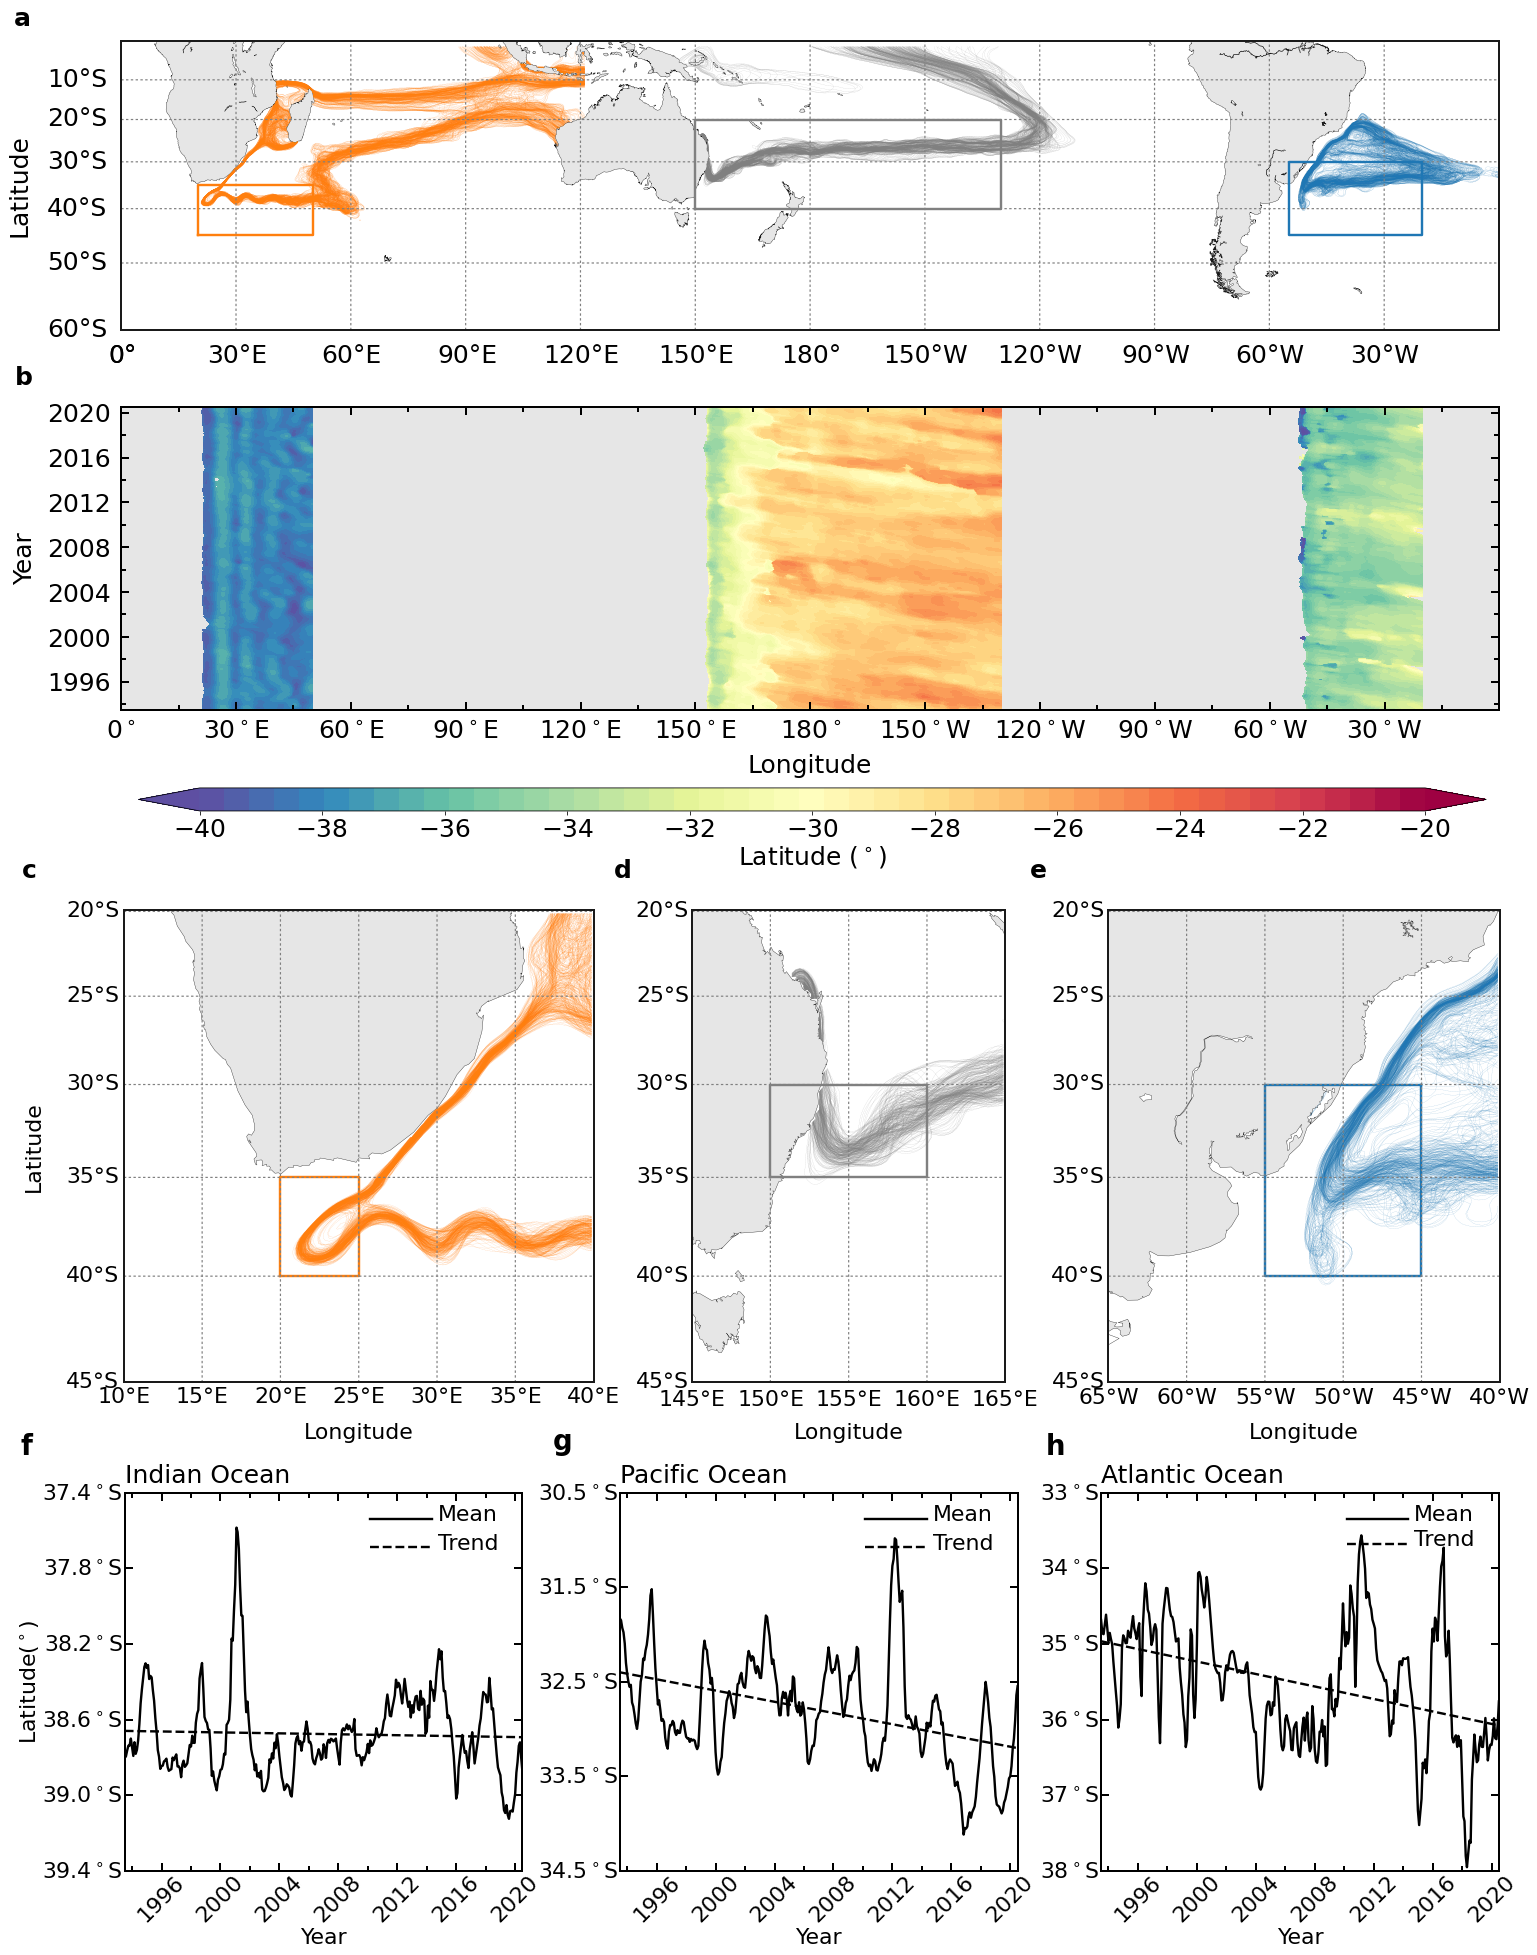

In [3]:
fig_ratio = 0.9
fig       = plt.figure(figsize=(24, 32))
gs        = gridspec.GridSpec(4,3)
labelfont     = 25
padspacescale = 10
labelpadscale = 2
linefont      = 1.2
scale1        = 1.59
scale2        = 1.25
labels1       = ['a','b','c','d','e','f','g','h']
labels2       = ['Indian Ocean','Pacific Ocean','Atlantic Ocean']
levels1       = np.linspace(-40,-20,50)
tick_marks1   = np.linspace(-40,-20,11)
cmaps1        = plt.cm.get_cmap('Spectral_r')
##################################################################################
# domains of Subtropical Gyres
lon_SG_ARC1 = np.array([20,50,50,20,20])
lat_SG_ARC1 = np.array([-45,-45,-35,-35,-45])
lon_SG_EAC1 = np.array([150,230,230,150,150])
lat_SG_EAC1 = np.array([-40,-40,-20,-20,-40])
lon_SG_BC1  = np.array([340,305,305,340,340])
lat_SG_BC1  = np.array([-30,-30,-45,-45,-30])
lon_SG_ARC2 = np.array([20,25,25,20,20])
lat_SG_ARC2 = np.array([-40,-40,-35,-35,-40])
lon_SG_EAC2 = np.array([150,160,160,150,150])
lat_SG_EAC2 = np.array([-35,-35,-30,-30,-35])
lon_SG_BC2  = np.array([315,305,305,315,315])
lat_SG_BC2  = np.array([-30,-30,-40,-40,-30])
############################### Row 1 ###################################
ax = fig.add_subplot(gs[0:2])
l, b, w, h = ax.get_position().bounds
m   = Basemap(projection='merc',llcrnrlat=-60,urcrnrlat= 0,llcrnrlon=0,urcrnrlon=360,resolution='l')    
m.drawmeridians(np.arange(0,360, 30),labels=[0,0,0,1],linewidth=linefont,dashes=[2,2],color='.5',fontsize=labelfont,family='sans-serif')
m.drawparallels(np.arange(-60,-0, 10),labels=[1,0,0,0],linewidth=linefont,dashes=[2,2],color='.5',fontsize=labelfont,family='sans-serif')    
m.drawcoastlines(color='0.1',  linewidth=0.3*linefont)
m.drawmapboundary(color='0.1', linewidth=0.5*linefont)
m.fillcontinents(color='0.9', lake_color='white')
x, y = m(lon, lat)
cx,cy  = m(-28, 4)
ax.set_position([l+0.005, b, scale1*w, scale1*h])   
ax.spines['left'].set_linewidth(labelpadscale)
ax.spines['top'].set_linewidth(labelpadscale)
ax.spines['right'].set_linewidth(labelpadscale)
ax.spines['bottom'].set_linewidth(labelpadscale)
for i in range(3):
    if i==0:
        SSH=large_scale_ssh1
    elif i==1:
        SSH=large_scale_ssh2
    else:
        SSH=large_scale_ssh3        
    for j in range(np.size(large_scale_ssh0,2)):
        if i<1:
            CS=m.contour(x, y,SSH[:,:,j],np.arange(0.89,0.91,10),linewidths=0.1*linefont,linestyles='dashed',colors='tab:orange')
        elif i<2:
            CS=m.contour(x, y,SSH[:,:,j],np.arange(0.89,0.91,10),linewidths=0.1*linefont,linestyles='dashed',colors='gray')
        else:
            CS=m.contour(x, y,SSH[:,:,j],np.arange(0.59,0.61,10),linewidths=0.1*linefont,linestyles='dashed',colors='tab:blue')    
x_SG_ARC1,y_SG_ARC1=m(lon_SG_ARC1,lat_SG_ARC1)
x_SG_EAC1,y_SG_EAC1=m(lon_SG_EAC1,lat_SG_EAC1)
x_SG_BC1,y_SG_BC1=m(lon_SG_BC1,lat_SG_BC1)
m.plot(x_SG_ARC1,y_SG_ARC1,linewidth=2*linefont,linestyle='solid', color='tab:orange')
m.plot(x_SG_EAC1,y_SG_EAC1,linewidth=2*linefont,linestyle='solid', color='gray')
m.plot(x_SG_BC1,y_SG_BC1,linewidth=2*linefont,linestyle='solid', color='tab:blue')
plt.ylabel('Latitude',fontsize=labelfont,labelpad=9*padspacescale,family='sans-serif')
ax.axes.xaxis.set_tick_params(pad=0)
ax.axes.yaxis.set_tick_params(pad=0)
plt.text(cx, cy,labels1[0],color='xkcd:black', fontsize=labelfont, weight='bold')
############################### Row 2 ###################################
# Plot latitudes of Subtropical Gyres
ax = fig.add_subplot(gs[3:5],facecolor='0.9')
l, b, w, h = ax.get_position().bounds
ax.set_position([l+0.005, b+0.1, 1.59*w, 0.8*h])   
ax.spines['left'].set_linewidth(labelpadscale)
ax.spines['top'].set_linewidth(labelpadscale)
ax.spines['right'].set_linewidth(labelpadscale)
ax.spines['bottom'].set_linewidth(labelpadscale)
CB = plt.contourf(x_lon, y_month, lat_SG, cmap=cmaps1,levels=levels1,origin='lower',extend='both')
plt.text(x_lon[0,-1]-28, y_month[-1,-1]+24, labels1[1],fontsize = labelfont, color='black', weight='bold')
# xaxis
xminorLocator   = plt.MultipleLocator(15)
xmajorLocator   = plt.MultipleLocator(30)
xmajorFormatter = plt.FormatStrFormatter('%2.0f')
ax.xaxis.set_minor_locator(xminorLocator)
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)        
ax.axes.xaxis.set_tick_params(pad=10)
plt.xticks(fontsize=labelfont,family='sans-serif')
plt.xticks(np.linspace(0,330,12), ['0$^\circ$', '30$^\circ$E', '60$^\circ$E','90$^\circ$E', '120$^\circ$E','150$^\circ$E',
           '180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W','60$^\circ$W','30$^\circ$W'])
plt.ylim(t_range[0], t_range[-1])
yminorLocator   = mpl.dates.YearLocator(2)
ymajorLocator   = mpl.dates.YearLocator(4)
ymajorFormatter = mpl.dates.DateFormatter('%Y')
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ymajorFormatter)
plt.yticks(fontsize=labelfont,family='sans-serif')
plt.tick_params(axis='x',which='minor',bottom='on',left='on',top='on',right='on',\
            length=5,width=2,colors='black',direction='in')
plt.tick_params(axis='y',which='minor',bottom='on',left='on',top='on',right='on',\
            length=5,width=2,colors='black',direction='in')
plt.tick_params(bottom='on',left='on',top='on',right='on',length=8.0,width=2,colors='black',direction='in')
ax.axes.yaxis.set_tick_params(pad=10) 
plt.ylabel('Year',fontsize=labelfont,labelpad=padspacescale,family='sans-serif')    
plt.xlabel('Longitude',fontsize=labelfont,labelpad=padspacescale,family='sans-serif')
cbaxes     = fig.add_axes([0.14, 0.575, 0.78, 0.01])
cb = plt.colorbar(CB,orientation='horizontal',cax = cbaxes)
cb.set_label(r'Latitude ($^\circ$)', fontsize=labelfont,labelpad=2,family='sans-serif')
cb.set_ticks(tick_marks1)
cb.ax.tick_params(labelsize=labelfont)
############################### Row 3 ###################################
labelfont2     = 22
for i in range(3):
    ax = fig.add_subplot(gs[i+6])
    l, b, w, h = ax.get_position().bounds
    b = b + 0.005
    if i==0:
        SSH   =large_scale_ssh1
        m     = Basemap(projection='merc',llcrnrlat=-45,urcrnrlat= -20+0.1,llcrnrlon=10,urcrnrlon=40,resolution='l')
        cx,cy = m(3.5, -18.0)
        x_SG_ARC2,y_SG_ARC2=m(lon_SG_ARC2,lat_SG_ARC2)
        m.plot(x_SG_ARC2,y_SG_ARC2,linewidth=2*linefont,linestyle='solid', color='tab:orange')
    elif i==1:
        l=l+0.01
        SSH   = large_scale_ssh2
        m     = Basemap(projection='merc',llcrnrlat=-45,urcrnrlat= -20+0.1,llcrnrlon=145,urcrnrlon=165,resolution='l')    
        cx,cy = m(140, -18.0)
        x_SG_EAC2,y_SG_EAC2=m(lon_SG_EAC2,lat_SG_EAC2)
        m.plot(x_SG_EAC2,y_SG_EAC2,linewidth=2*linefont,linestyle='solid', color='gray')
    else:
        SSH   = large_scale_ssh3  
        m     = Basemap(projection='merc',llcrnrlat=-45,urcrnrlat= -20+0.1,llcrnrlon=295,urcrnrlon=320,resolution='l')    
        cx,cy = m(290, -18.0)
        x_SG_BC2,y_SG_BC2=m(lon_SG_BC2,lat_SG_BC2)
        m.plot(x_SG_BC2,y_SG_BC2,linewidth=2*linefont,linestyle='solid', color='tab:blue')
    m.drawmeridians(np.arange(0,360,  5),labels=[0,0,0,1],linewidth=linefont,dashes=[2,2],color='.5',fontsize=labelfont2,family='sans-serif')
    m.drawparallels(np.arange(-60,-0, 5),labels=[1,0,0,0],linewidth=linefont,dashes=[2,2],color='.5',fontsize=labelfont2,family='sans-serif')    
    m.drawcoastlines(color='0.1',  linewidth=0.3*linefont)
    m.drawmapboundary(color='0.1', linewidth=0.5*linefont)
    m.fillcontinents(color='0.9', lake_color='white')
    x, y = m(lon, lat)
    for j in range(np.size(large_scale_ssh0,2)):
        if i==0:
            plt.ylabel('Latitude',fontsize=labelfont2,labelpad=8*padspacescale,family='sans-serif')
            CS=m.contour(x, y,SSH[:,:,j],np.arange(0.89,0.91,10),linewidths=0.1*linefont,linestyles='dashed',colors='tab:orange')
        elif i==1:
            CS=m.contour(x, y,SSH[:,:,j],np.arange(0.89,0.91,10),linewidths=0.1*linefont,linestyles='dashed',colors='gray')
        else:
            CS=m.contour(x, y,SSH[:,:,j],np.arange(0.59,0.61,10),linewidths=0.1*linefont,linestyles='dashed',colors='tab:blue')    
    ax.set_position([l, b, scale2*w, scale2*h])   
    ax.spines['left'].set_linewidth(labelpadscale)
    ax.spines['top'].set_linewidth(labelpadscale)
    ax.spines['right'].set_linewidth(labelpadscale)
    ax.spines['bottom'].set_linewidth(labelpadscale)
    plt.text(cx, cy,labels1[i+2],color='xkcd:black', fontsize=labelfont, weight='bold')
    plt.xlabel('Longitude',fontsize=labelfont2,labelpad=4*padspacescale,family='sans-serif')
    ax.axes.xaxis.set_tick_params(pad=0)
    ax.axes.yaxis.set_tick_params(pad=0)
############################### Row 4 ###################################
for i in range(3):
    ax = fig.add_subplot(gs[i+9]) 
    l, b, w, h = ax.get_position().bounds
    if i<1:
        l=l+0.007
        plt.plot(t_range, lat_SG_ARC_mean, color='black', linewidth=2*linefont)
        plt.plot(t_range, lat_SG_ARC_trend, color='black', linewidth=2*linefont,linestyle='dashed')
        plt.text(t_range[0]-85, -37.2, labels1[i+5],fontsize = 1.25*labelfont2, color='black', weight='bold')
    elif i<2:
        l=l+0.020
        plt.plot(t_range, lat_SG_EAC_mean, color='black', linewidth=2*linefont)
        plt.plot(t_range, lat_SG_EAC_trend, color='black', linewidth=2*linefont,linestyle='dashed')
        plt.text(t_range[0]-55, -30.05, labels1[i+5],fontsize = 1.25*labelfont2, color='black', weight='bold')
    else:
        l=l+0.025
        plt.plot(t_range, lat_SG_BC_mean, color='black', linewidth=2*linefont)
        plt.plot(t_range, lat_SG_BC_trend, color='black', linewidth=2*linefont,linestyle='dashed')
        plt.text(t_range[0]-45, -32.5, labels1[i+5],fontsize = 1.25*labelfont2, color='black', weight='bold')
        
    ax.set_position([l, b-0.01, w*1.01, h])
    plt.title(labels2[i], fontsize=labelfont,loc='left',pad=padspacescale,family='sans-serif')
    plt.xlim(t_range[0], t_range[-1])
    xminorLocator   = mpl.dates.YearLocator(2)
    xmajorLocator   = mpl.dates.YearLocator(4)
    xmajorFormatter = mpl.dates.DateFormatter('%Y')
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_major_formatter(xmajorFormatter)
    plt.xticks(fontsize=labelfont2,rotation=45)
    ax.axes.xaxis.set_tick_params(pad=labelpadscale*0.5)
    plt.xlabel('Year',fontsize=labelfont2,labelpad=2,family='sans-serif')
    if i<1:
        plt.ylim(-39.4, -37.4)
        yminorLocator   = plt.MultipleLocator(0.1)
        ymajorLocator   = plt.MultipleLocator(0.2)        
        plt.plot([t_range[200],t_range[250]], [-37.54,-37.54], color='black', linewidth=2*linefont)
        plt.plot([t_range[200],t_range[250]], [-37.69,-37.69], color='black', linewidth=2*linefont,linestyle='dashed')
        plt.text(t_range[255], -37.55, 'Mean',fontsize = labelfont2, color='black',family='sans-serif')
        plt.text(t_range[255], -37.70, 'Trend',fontsize = labelfont2, color='black',family='sans-serif')
        plt.ylabel(r'Latitude($^\circ$)',fontsize=labelfont2,labelpad=0,family='sans-serif')
        ax.set_yticks(np.linspace(-39.4, -37.4,6))
        ax.set_yticklabels(['39.4$^\circ$S','39.0$^\circ$S','38.6$^\circ$S','38.2$^\circ$S','37.8$^\circ$S','37.4$^\circ$S'])
    elif i<2:
        yminorLocator   = plt.MultipleLocator(0.5)
        ymajorLocator   = plt.MultipleLocator(1)
        plt.ylim(-34.5, -30.5)
        plt.plot([t_range[200],t_range[250]], [-30.78,-30.78], color='black', linewidth=2*linefont)
        plt.plot([t_range[200],t_range[250]], [-31.08,-31.08], color='black', linewidth=2*linefont,linestyle='dashed')
        plt.text(t_range[255], -30.8, 'Mean',fontsize = labelfont2, color='black',family='sans-serif')
        plt.text(t_range[255], -31.1, 'Trend',fontsize = labelfont2, color='black',family='sans-serif')
        ax.set_yticks(np.linspace(-34.5, -30.5,5))
        ax.set_yticklabels(['34.5$^\circ$S','33.5$^\circ$S','32.5$^\circ$S','31.5$^\circ$S','30.5$^\circ$S'])
    else:
        yminorLocator   = plt.MultipleLocator(1)
        ymajorLocator   = plt.MultipleLocator(1)
        plt.ylim(-38, -33)  
        plt.plot([t_range[200],t_range[250]], [-33.35,-33.35], color='black', linewidth=2*linefont)
        plt.plot([t_range[200],t_range[250]], [-33.675,-33.675], color='black', linewidth=2*linefont,linestyle='dashed')
        plt.text(t_range[255], -33.375, 'Mean',fontsize = labelfont2, color='black',family='sans-serif')
        plt.text(t_range[255], -33.7, 'Trend',fontsize = labelfont2, color='black',family='sans-serif')
        ax.set_yticks(np.linspace(-38,-33,6))
        ax.set_yticklabels(['38$^\circ$S','37$^\circ$S','36$^\circ$S','35$^\circ$S','34$^\circ$S','33$^\circ$S'])
    plt.yticks(fontsize=labelfont2,family='sans-serif')
    ax.axes.yaxis.set_tick_params(pad=labelpadscale)
    ax.spines['bottom'].set_linewidth(labelpadscale)
    ax.spines['left'].set_linewidth(labelpadscale)
    ax.spines['top'].set_linewidth(labelpadscale)
    ax.spines['right'].set_linewidth(labelpadscale)
    plt.tick_params(axis='x',which='minor',bottom='on',left='on',top='on',right='on',\
                length=5,width=2,colors='black',direction='in')
    plt.tick_params(axis='y',which='minor',bottom='on',left='on',top='on',right='on',\
                length=5,width=2,colors='black',direction='in')
    plt.tick_params(bottom='on',left='on',top='on',right='on',length=8.0,width=2,colors='black',direction='in')
fig.savefig(directory+'/BRAN_WBC/SO/Figure4_ssh_contour.pdf',dpi=300,bbox_inches = 'tight')